[Step 1]: Load model.
[Step 2]: Get images.
[Step 3]: Tile image.
[Step 4]: Do inference.
[Step 5]: Save figure at path './display.png'
[data] ['./display.png', '10.6%', '83.4%', '6.0%', '0.0%', 'useful suggestion']


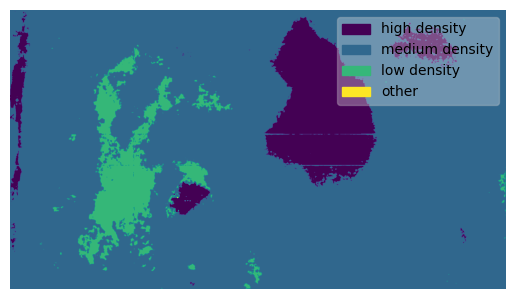

In [17]:
# ================== #
# Step 1: load model #
# ================== #
print("[Step 1]: Load model.")
import tensorflow as tf
segmentation_model = tf.keras.models.load_model("model_UNet")

# ================== #
# Step 2: Get Images #
# ================== #
print("[Step 2]: Get images.")
import cv2 as cv
import numpy as np
samples = ["Sample_01", "Sample_02", "Sample_03"]
idx = 0 # or 1 or 2
img_b = cv.imread(f"./test_sample/{samples[idx]}_B.jpg") # 這會是你選定的第一張影像
img_d = cv.imread(f"./test_sample/{samples[idx]}_D.jpg") # 這會是你選定的第二張影像
img = np.concatenate((img_b, img_d), axis=2)
img = img / 255 # feature scaling

# ================== #
# Step 3: Tile Image #
# ================== #
print("[Step 3]: Tile image.")
tile_size = 480
tiles, img_height, img_width = tile_up(img, tile_size)

# ================= #
# Step 4: Inference #
# ================= #
print("[Step 4]: Do inference.")
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
full_mask = np.zeros((img_height, img_width))
for tile in tiles:
    crop = tile["crop"]
    start_h, end_h, start_w, end_w = tile["position"]
    pred_y = segmentation_model(crop)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask.numpy()
    full_mask[start_h: end_h, start_w: end_w] = pred_mask
    
# ============================ #
# Step 5: Plot and Save Figure #
# ============================ #
print("[Step 5]: Save figure at path \'./display.png\'")
plot_and_save_fig(full_mask, viz=False)

# ==================== #
# Step 6: Prepare JSON #
# ==================== #
data = analyze(full_mask, img_height, img_width) # 這個 data 就是你要的
print(f"[data] {data}")

In [16]:
def analyze(full_mask, img_w, img_h):
    count_high_density = np.sum(full_mask==1)
    count_medium_density = np.sum(full_mask==2)
    count_low_density = np.sum(full_mask==3)
    count_other = np.sum(full_mask==4) + np.sum(full_mask==0)
    
    high_density = f"{'%.1f' % (count_high_density / (img_w * img_h) * 100)}%"
    medium_density = f"{'%.1f' % (count_medium_density / (img_w * img_h) * 100)}%"
    low_density = f"{'%.1f' % (count_low_density / (img_w * img_h) * 100)}%"
    other = f"{'%.1f' % (count_other / (img_w * img_h) * 100)}%"
    data = ["./display.png", high_density, medium_density, low_density, other, "useful suggestion"]
    return data

In [2]:
def plot_and_save_fig(full_mask, viz):
    legend_text = ["background", "high density", "medium density", "low density", "other"]
    values = [0,1,2,3,4]
    im = plt.imshow(full_mask, vmin=1, vmax=4)
    colors = [ im.cmap(im.norm(value)) for value in values]
    patches = [ mpatches.Patch(color=colors[i], label=f"{legend_text[i]}") for i in range(1,len(values))]

    plt.legend(handles=patches, framealpha=0.3)
    plt.axis("off")
    plt.savefig("display.png")
    if viz:
        plt.show()

In [3]:
def tile_up(img, tile_size):
    h, w, c = img.shape
    h_num = h // tile_size
    w_num = w // tile_size
    
    tiles = list()
    
    for hn in range(h_num):
        for wn in range(w_num):
            start_h = tile_size * hn
            start_w = tile_size * wn
            end_h   = tile_size * (hn+1)
            end_w   = tile_size * (wn+1)
            crop = img[start_h:end_h, start_w:end_w]
            crop = crop[np.newaxis, ...]
            position = [start_h, end_h, start_w, end_w]
            tile = {"crop": crop, "position": position}
            tiles.append(tile)
            
    # True 表示 height 方向沒有辦法被 tile_size 整除，所以還有剩下一些區域需要 handle
    if (h - end_h > 0):
        for wn in range(w_num):
            start_h = h - tile_size
            end_h   = h
            start_w = tile_size * wn
            end_w   = tile_size * (wn+1)
            crop = img[start_h:end_h, start_w:end_w]
            crop = crop[np.newaxis, ...]
            position = [start_h, end_h, start_w, end_w]
            tile = {"crop": crop, "position": position}
            tiles.append(tile)

    # True 表示 width 方向沒有辦法被 tile_size 整除，所以還有剩下一些區域需要 handle
    if (w - end_w > 0):
        for hn in range(h_num):
            start_h = tile_size * hn
            end_h   = tile_size * (hn+1)
            start_w = w - tile_size
            end_w   = w
            crop = img[start_h:end_h, start_w:end_w]
            crop = crop[np.newaxis, ...]
            position = [start_h, end_h, start_w, end_w]
            tile = {"crop": crop, "position": position}
            tiles.append(tile)
            
    # True 表示右下角需要被 handle
    if (h - end_h > 0) and (w - end_w > 0):
        start_h = h - tile_size
        end_h   = h
        start_w = w - tile_size
        end_w   = w
        crop = img[start_h:end_h, start_w:end_w]
        position = [start_h, end_h, start_w, end_w]
        tile = {"crop": crop, "position": position}
        tiles.append(tile)
        
    return tiles, h, w